# Install Pytorch

Install WSL if you are using Windows: https://learn.microsoft.com/en-us/windows/wsl/install

Install CUDA if you have an NVIDA GPU in your computer/laptop: https://developer.nvidia.com/cuda-12-4-1-download-archive?target_os=Linux&target_arch=x86_64&Distribution=WSL-Ubuntu&target_version=2.0&target_type=deb_local

Install Pytorch using pip: https://pytorch.org/get-started/locally/

Please install the version that best suits your env, if you don't have a GPU use the CPU installation (the issue with this is that takes a lot of time to train the image classifier). You will be creating a python venv for this project

# Verify that you have Pytorch installed and ready to go

In [1]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.6.0
False


In [2]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


# Developing an AI application

In this project, you will train an image classifier to identify various species of flowers. Imagine using this in a mobile app that can recognize and name flowers captured by your camera. In practice, you would train the classifier and then export it for integration into your application. We'll be working with a dataset containing 102 flower categories; a few examples are shown below.

![Image Example - 1](./resources/image_08115.jpg)
![Image Example - 2](./resources/image_08124.jpg)

## Project Steps

The project is divided into several key steps to guide you through building a functional image classifier:

1. **Load and preprocess the image dataset**  
   Prepare your data for training by resizing, normalizing, and organizing the images.  
2. **Train the image classifier on your dataset**  
   Use deep learning techniques to teach the model to recognize patterns in the images.  
3. **Use the trained classifier to predict image content**  
   Test the model by feeding it new images and evaluating its predictions.

I'll walk you through each of these steps, which you’ll implement in Python, offering hands-on experience with practical machine learning techniques.

---

By the end of this project, you’ll have developed an application capable of training on any labeled image dataset. For this specific example, your network will learn to identify flower species and be implemented as a command-line application. However, the possibilities with your newly acquired skills are endless! 

For example, imagine creating an app where you take a picture of a car, and it tells you the make and model, complete with additional information. The only limit is your creativity and effort in curating a dataset.

---

### Getting Started: Importing Packages

Before diving in, let’s start with a good programming practice: **importing necessary packages at the start of your code**. This helps maintain organization and clarity. As you progress through the notebook and identify additional packages needed, be sure to add them to the imports section at the top. This way, your code remains clean and professional.


In [3]:
# Imports here

from torchvision import datasets, transforms, models
from torch import nn, optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the data

To get started, click the link below and sign in with your NorQuest Microsoft account to download the dataset:   
[Download the Data](https://norquest-my.sharepoint.com/:u:/g/personal/mario_sorianomorales_norquest_ca/EV1fG1Ja8bBEvGSE90c9dscBbhPqdjf0Mh5SNOe-fXIJQA?e=C3rjvT)

After downloading, create a folder named **"flowers"** and place the extracted data inside it. Follow the steps below to complete this process:

In [6]:
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers

# Data Description

The dataset is divided into three parts: **training**, **validation**, and **testing**. Each subset serves a specific purpose in training and evaluating your model:

### Training Data
The training set is used to teach the model how to recognize patterns in the images. To improve generalization and prevent overfitting, you'll apply various transformations such as:
- **Random scaling**: Varying the size of the image randomly.
- **Random cropping**: Selecting random sections of the image.
- **Random flipping**: Horizontally flipping the images.

These transformations create a more diverse dataset, helping the model perform better on unseen data. Additionally, all input images must be resized to **224x224 pixels**, which is the input size expected by the pre-trained networks you'll be using.

---

### Validation and Testing Data
The **validation set** is used during training to monitor the model's performance on unseen data and fine-tune hyperparameters. The **testing set**, on the other hand, is reserved for the final evaluation of the model's accuracy after training is complete. 

For these datasets:
- You **should not** apply scaling, rotation, or flipping transformations. 
- You **should** resize the images to 256 pixels on the shortest side and then center crop them to **224x224 pixels** to match the training data's dimensions.

---

### Normalization
The pre-trained networks you’ll use, such as those available in PyTorch’s `torchvision` library, were trained on the **ImageNet dataset**. To align with these networks, you need to normalize the images in all three datasets (training, validation, and testing). This involves adjusting each color channel (red, green, and blue) to have specific means and standard deviations:

- **Means**: `[0.485, 0.456, 0.406]`
- **Standard Deviations**: `[0.229, 0.224, 0.225]`

Normalization ensures that the pixel values for each color channel are centered around 0 and have a range approximately between -1 and 1. This preprocessing step is crucial as it matches the distribution expected by the pre-trained network, enabling it to produce accurate predictions.

By following these preprocessing steps, your model will be well-prepared to leverage the power of transfer learning with pre-trained networks.


In [4]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [5]:
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize(225),
                                      transforms.CenterCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

train_data = datasets.ImageFolder(train_dir, transform = data_transforms)
test_data = datasets.ImageFolder(test_dir, transform = data_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform = data_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)

# Label Mapping

To make the predictions from your model more interpretable, you’ll need to load a mapping from category labels to their corresponding flower names. This mapping is provided in a file named **`cat_to_name.json`**. 

The file contains a **JSON object** that maps integer-encoded category labels to the actual names of the flowers. For example:
```json
{
  "1": "rose",
  "2": "sunflower",
  "3": "daisy"
}
```
To work with this mapping in Python:

1. Use the json module to read the file.
2. Load the JSON object into a Python dictionary.

This mapping will allow your model’s predictions (which are in the form of numeric labels) to be translated into meaningful flower names, making it easier to interpret and present the results.

Here’s how to load the mapping:

In [6]:
import json

# Load the category-to-name mapping
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

print(cat_to_name["1"])  # Output: "pink primrose"

pink primrose


# Building and Training the Classifier

With the data prepared, it's time to focus on building and training the classifier. This involves leveraging a **pre-trained model** from `torchvision.models` to extract image features and then constructing a custom feed-forward classifier to make predictions. This approach, known as **transfer learning**, saves time and computational resources while improving model performance.

### Steps to Complete This Section
This part is already implemented for you, but here’s a breakdown of what needs to be done:

1. **Load a Pre-trained Network**  
   Choose one of the pre-trained models from `torchvision.models`. A great starting point is the **VGG** family of networks (e.g., `vgg16`), which are simple to use and highly effective for image classification tasks.

2. **Define a New Feed-forward Classifier**  
   - Replace the pre-trained model’s classifier with a new, untrained feed-forward network.  
   - Use **ReLU activations** for non-linearity and **dropout** to prevent overfitting.  
   - Match the number of output units to the number of flower categories in your dataset (e.g., 102 classes).

3. **Train the Classifier**  
   - Train the newly defined classifier layers using **backpropagation**, while keeping the pre-trained network’s feature extraction layers frozen (do not update their weights).  
   - Use an optimizer like `Adam` or `SGD` and monitor the **loss** and **accuracy** on the **validation set** to identify the best hyperparameters.

4. **Track Performance**  
   - Evaluate the model on the validation set after each epoch to track progress.  
   - Experiment with hyperparameters such as the learning rate, number of hidden units, dropout probability, and number of epochs.  

---

### Recommendations for Workflow
- **Break the problem into smaller steps**: Implement and test each part (e.g., loading the model, defining the classifier, training) individually before moving on. This iterative process will help you debug more effectively.  
- **Monitor GPU usage**: If you are using a GPU, ensure you are fully utilizing it to speed up training.  

---

### Tips for Success
- **Focus on Fine-tuning Hyperparameters**: With proper tuning, you should achieve a validation accuracy of at least **70%**. Save the best hyperparameters for use in the next stages of the project.  
- **Save Your Progress**: Regularly save your model and hyperparameters to prevent loss of work. Use frameworks like `torch.save()` to store the model state.

---

### Keep Your Session Active
The process can be long, so make sure your session is active and do not close your kernel!


## Define your device and model selection

Select a model from the following list supported by Pythorch

https://pytorch.org/vision/main/models.html#classification

In [7]:
device = torch.device("mps")
architecture = 'vgg19'
model = models.vgg19(pretrained=True)
model

/opt/anaconda3/envs/pytorch_mac/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/pytorch_mac/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/mario/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [8]:
model.classifier = nn.Sequential(nn.Linear(25088, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 102),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

In [9]:
epochs = 5
steps = 0
running_loss = 0
print_every = 5

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps +=1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    valid_loss += batch_loss.item()
                    
                    #Calculate accuracy
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.."
                  f"Train loss: {running_loss/print_every:.3f}.."
                  f"Valid loss: {valid_loss/len(validloader):.3f}.."
                  f"Valid accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/5..Train loss: 10.273..Valid loss: 7.683..Valid accuracy: 0.094
Epoch 1/5..Train loss: 6.292..Valid loss: 4.699..Valid accuracy: 0.138
Epoch 1/5..Train loss: 4.471..Valid loss: 4.111..Valid accuracy: 0.149
Epoch 1/5..Train loss: 3.998..Valid loss: 3.977..Valid accuracy: 0.166
Epoch 1/5..Train loss: 3.934..Valid loss: 3.850..Valid accuracy: 0.160
Epoch 1/5..Train loss: 3.936..Valid loss: 3.550..Valid accuracy: 0.214
Epoch 1/5..Train loss: 3.489..Valid loss: 3.416..Valid accuracy: 0.263
Epoch 1/5..Train loss: 3.374..Valid loss: 3.278..Valid accuracy: 0.305
Epoch 1/5..Train loss: 3.456..Valid loss: 3.095..Valid accuracy: 0.299
Epoch 1/5..Train loss: 3.440..Valid loss: 2.838..Valid accuracy: 0.368
Epoch 1/5..Train loss: 2.970..Valid loss: 2.887..Valid accuracy: 0.318
Epoch 1/5..Train loss: 2.983..Valid loss: 2.944..Valid accuracy: 0.330
Epoch 1/5..Train loss: 2.960..Valid loss: 2.775..Valid accuracy: 0.334
Epoch 1/5..Train loss: 2.955..Valid loss: 2.548..Valid accuracy: 0.400
Epoch

### Testing Your Trained Network

Testing your trained network is a crucial step in evaluating its performance. It’s important to use a **test dataset**—a set of images the network has never encountered during training or validation. This process provides a reliable estimate of how well the model will generalize to entirely new, unseen data.

To perform the test, pass the test images through the network and calculate the accuracy, similar to how you measured validation accuracy during training. If your model has been trained effectively, you should aim for an accuracy of approximately **70%** on the test set. This benchmark indicates that the network has learned meaningful features and can make accurate predictions on data it hasn’t been exposed to.

Remember, a lower accuracy might suggest overfitting (where the model performs well on training data but poorly on new data) or underfitting (where the model hasn’t learned enough from the training data). Use this testing phase as an opportunity to refine your model further if needed.


In [10]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)
                    
        test_loss += batch_loss.item()
                    
        #Calculate accuracy
                    
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
print(f"Epoch {epoch+1}/{epochs}.."      
      f"Test accuracy: {accuracy/len(testloader):.3f}")

Epoch 5/5..Test accuracy: 0.700


### Saving the Model Checkpoint

After training your network, it’s essential to save the model so you can load it later for making predictions or further training. In addition to saving the model’s state, consider preserving other crucial information, such as the mapping of class labels to indices, which can be retrieved from the training dataset:

```python
model.class_to_idx = image_datasets['train'].class_to_idx
```
Attaching this mapping as an attribute to the model makes inference easier later when you need to map predictions back to their respective classes.

When saving the checkpoint, remember that you’ll need all the necessary information to rebuild the model completely for inference. This includes:

* The model architecture
* The model's state dictionary (model.state_dict)
* The mapping of classes to indices (class_to_idx)

If you plan to resume training the model, also save:

* The number of completed epochs
* The optimizer’s state (optimizer.state_dict)


In [11]:
def save_checkpoint(model, optimizer, epoch, loss, class_to_idx, architecture, file_path='checkpoint.pth'):
    try:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'class_to_idx': class_to_idx,
            'architecture': architecture,
            'classifier': model.classifier
        }
        
        # Save the checkpoint
        torch.save(checkpoint, file_path)
        print(f"Checkpoint saved successfully to {file_path}")
    except Exception as e:
        print(f"Error saving checkpoint: {e}")

In [12]:
class_to_idx = train_data.class_to_idx
save_checkpoint(model, optimizer, epoch, loss, class_to_idx, architecture, file_path='checkpoint_3.pth')

Checkpoint saved successfully to checkpoint_3.pth


In [48]:
checkpoint = torch.load('checkpoint_3.pth')
print(checkpoint.keys())

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'class_to_idx', 'architecture', 'classifier'])


### Loading the Model Checkpoint

It’s a good practice to create a function for loading a saved checkpoint and rebuilding the model. This allows you to return to the project later and continue working without needing to retrain the network from scratch. Such a function ensures reproducibility and makes it easier to deploy or fine-tune your model in the future.

The function should:
- Load the checkpoint file.
- Extract the saved information, such as the model’s architecture, state dictionary, class-to-index mapping, and optimizer state (if applicable).
- Reconstruct the model using the saved architecture and load its parameters.

In [49]:
def load_checkpoint(file_path='checkpoint.pth'):
    try:
        # Load the checkpoint
        checkpoint = torch.load(file_path)
        
        # Load the model architecture
        architecture = checkpoint.get('architecture', 'vgg19')
        model = getattr(models, architecture)(pretrained=True)
        
        # Rebuild the classifier
        if 'classifier' in checkpoint:
            model.classifier = checkpoint['classifier']
        
        # Load the state dictionaries
        model.load_state_dict(checkpoint['model_state_dict'])
        model.class_to_idx = checkpoint.get('class_to_idx', {})
        
        # Optional: Print details
        epoch = checkpoint.get('epoch', 'Unknown')
        loss = checkpoint.get('loss', 'Unknown')
        print(f"Checkpoint loaded from {file_path}: epoch {epoch}, loss {loss}")
        
        return model
    except Exception as e:
        print(f"Error loading checkpoint: {e}")


With this function in place, you’ll be able to reload your model and all relevant settings quickly, enabling seamless transitions between training, testing, and deployment phases. This step is particularly important if you plan to use the model for inference or further training in the next stages of your project.

In [50]:
loaded_model = load_checkpoint(file_path='checkpoint_3.pth')

Checkpoint loaded from checkpoint_3.pth: epoch 4, loss 0.7278437614440918


## Inference for Classification

To perform inference for classification, you'll need to create a function that utilizes a trained model to predict the class of a flower in a given image. This function, named `predict`, will take two inputs: an image and the model. It will output the top **K** most likely classes along with their respective probabilities. For example, when you call the function as follows:

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
```

You might get results like this:
```python
[0.01558163, 0.01541934, 0.01452626, 0.01443549, 0.01407339]
['70', '3', '45', '62', '55']
```

The function will consist of two main steps: preprocessing the input image and making predictions using the model.


### Step 1: Image Preprocessing

The input image must be prepared in the same way as the images were processed during training to ensure the model can interpret the input correctly. This involves:

1. **Loading the Image**  
   Use the `PIL` library to load the image. This library is efficient for handling image data and supports a wide range of file formats.

2. **Resizing**  
   Adjust the image size so that the shortest side is 256 pixels while maintaining the aspect ratio. This can be achieved using the `thumbnail` or `resize` methods of the `PIL.Image` class.

3. **Cropping**  
   Extract the central 224x224 portion of the resized image to match the input size expected by the model.

4. **Scaling**  
   Image pixel values, typically represented as integers in the range of 0 to 255, need to be converted to floats between 0 and 1. This can be easily accomplished by converting the image to a NumPy array and dividing by 255.

5. **Normalization**  
   The model expects the input to be normalized using specific mean and standard deviation values for each color channel:
   - **Means**: `[0.485, 0.456, 0.406]`
   - **Standard deviations**: `[0.229, 0.224, 0.225]`  
   Subtract the mean and divide by the standard deviation for each channel to normalize the image.

6. **Reordering Dimensions**  
   PyTorch models expect the color channel to be the first dimension (channels-first format). However, images are typically in channels-last format (height, width, channels). Use `ndarray.transpose` to reorder the dimensions appropriately.

---

### Step 2: Model Inference

Once the image is preprocessed, pass it through the model to obtain predictions. The output will be probabilities corresponding to each class. To get the top **K** predictions:
- Use PyTorch's `torch.topk` method on the output probabilities.
- Extract the top **K** probabilities and their corresponding class indices.
- Convert the indices back to class labels using the `class_to_idx` mapping stored in your model.


In [52]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a NumPy array.
    '''
    try:
        # Open the image file
        pil_image = Image.open(image_path).convert("RGB")
        
        # Resize while maintaining aspect ratio
        pil_image.thumbnail((256, 256))
        
        # Center crop to 224x224
        width, height = pil_image.size
        new_width, new_height = 224, 224
        left = (width - new_width) / 2
        top = (height - new_height) / 2
        right = (width + new_width) / 2
        bottom = (height + new_height) / 2
        pil_image = pil_image.crop((left, top, right, bottom))
        
        # Convert to numpy array
        np_image = np.array(pil_image) / 255.0
        
        # Normalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        np_image = (np_image - mean) / std
        
        # Reorder dimensions to PyTorch format (channels-first)
        np_image = np_image.transpose((2, 0, 1))
        
        return np_image

    except FileNotFoundError:
        print(f"Error: File {image_path} not found.")
        return None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your process_image function works, running the output through this function should return the original image (except for the cropped out portions).

In [53]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    if title:
        ax.set_title(title)
    
    return ax

In [54]:
test_image_processed = process_image("./resources/image_08124.jpg")

<Axes: >

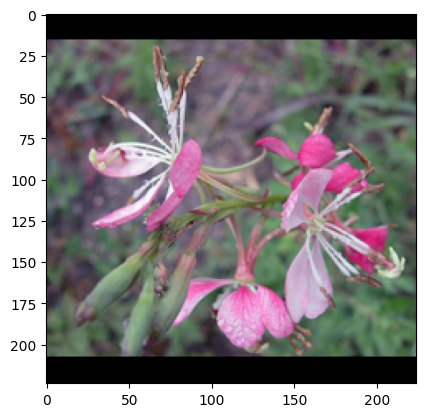

In [55]:
imshow(test_image_processed)

### Class Prediction

After formatting images correctly, the next step is to create a function for making predictions using your trained model. A common approach is to calculate the probabilities for each class and then select the top **K** most probable classes. This process, often referred to as "top-K predictions," helps identify the most likely classifications the model can make for a given input.

To identify the top **K** predictions, use the `x.topk(k)` method on the output tensor. This function returns two outputs:
1. The top **K** probabilities, which represent the confidence levels for the predictions.
2. The indices corresponding to these probabilities, which map to the class labels.

Since these indices correspond to numerical mappings in `class_to_idx` (a dictionary that maps class labels to indices), you’ll need to convert them back to the actual class labels. If you saved the `class_to_idx` mapping in your model or retrieved it from the `ImageFolder` used during training, you can use it here. To make this conversion straightforward:
- Invert the `class_to_idx` dictionary so you can map indices back to their corresponding class labels.

Your function should take the following inputs:
1. A path to an image.
2. A trained model.

t should return the top **K** probabilities and their associated class labels. For example:

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
```

Output:

```python
[0.01558163, 0.01541934, 0.01452626, 0.01443549, 0.01407339]
['70', '3', '45', '62', '55']
```

This setup ensures you can interpret the model's predictions effectively and retrieve the most likely class labels with their associated probabilities. This approach is particularly useful for tasks like image classification, where you might want to explore alternative predictions beyond just the top one.

In [56]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model. '''
    
    # Process the image
    np_image = process_image(image_path)
    
    # Convert to PyTorch tensor
    tensor_image = torch.from_numpy(np_image).type(torch.FloatTensor)
    
    # Add batch dimension
    tensor_image = tensor_image.unsqueeze(0)
    
    # Move model and tensor to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    tensor_image = tensor_image.to(device)
    
    # Set the model to evaluation mode and make predictions
    model.eval()
    with torch.no_grad():
        output = model(tensor_image)
    
    # Convert output to probabilities
    ps = torch.exp(output)
    
    # Get the top k probabilities and classes
    top_ps, top_indices = ps.topk(topk, dim=1)
    
    # Move to CPU and convert to lists
    top_ps = top_ps.cpu().numpy().flatten()
    top_indices = top_indices.cpu().numpy().flatten()
    
    # Ensure class_to_idx exists
    if not hasattr(model, "class_to_idx"):
        raise AttributeError("Model does not have class_to_idx attribute.")
    
    # Invert class_to_idx mapping
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    
    # Map indices to actual class labels
    top_classes = [idx_to_class[idx] for idx in top_indices]
    
    return top_ps, top_classes

In [58]:
# Predict the top 5 classes
image_path = './resources/image_08124.jpg'

# Predict the top 5 classes
probs, classes = predict(image_path, loaded_model)
print(probs)
print(classes)

[9.8743302e-01 5.6576291e-03 2.3389559e-03 1.0817238e-03 9.5974858e-04]
['57', '61', '92', '36', '37']


### Sanity Checking

Now that you have a trained model capable of making predictions, it’s essential to verify that the predictions make sense. Even if the model achieves high testing accuracy, manual checks can help ensure there are no obvious bugs or mismatches in the workflow. For example, predictions might be misaligned due to an error in class mapping or preprocessing.

To validate predictions visually:
1. Use **Matplotlib** to create a bar graph showing the probabilities of the top 5 predicted classes.
2. Display the input image alongside the bar graph for context, allowing you to visually confirm whether the predictions align with the expected flower type.

To enhance the visualization, you can map the class integer encodings to their corresponding flower names. This can be done using the `cat_to_name.json` file, which provides a mapping from class indices to human-readable flower names. Ensure this file has been loaded earlier in the notebook to facilitate this conversion.

If you’re working with a PyTorch tensor representation of the image, use the `imshow` function (defined earlier) to convert it back into a displayable image format. This step allows for easy comparison between the input image and the predicted class labels, making sanity checks more intuitive.

Performing this kind of sanity check is a good practice for identifying issues early, such as incorrect preprocessing steps, model misconfiguration, or inconsistencies in the dataset.


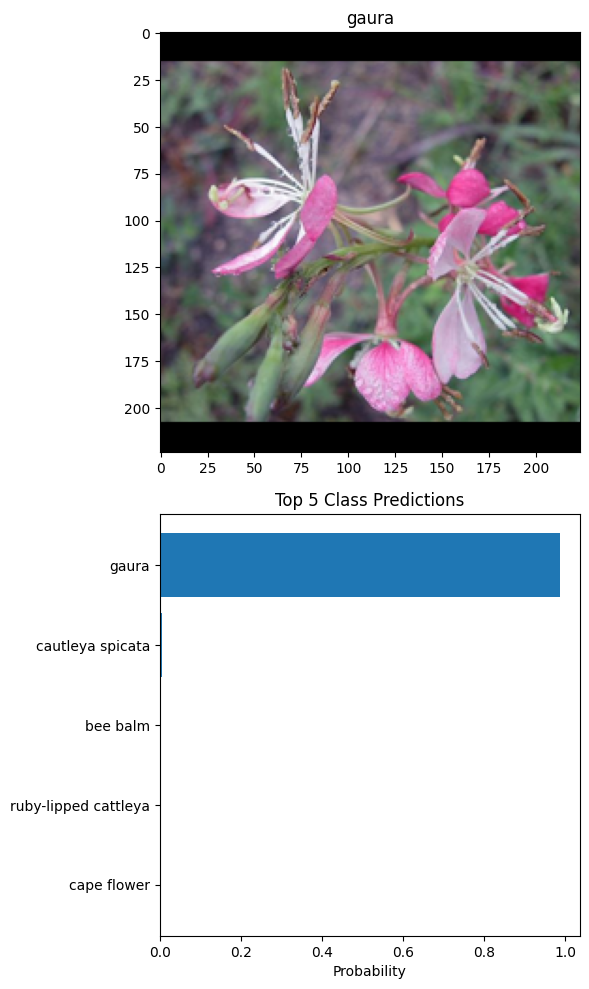

In [59]:
image = process_image("./resources/image_08124.jpg")

class_names = [cat_to_name[name] for name in classes]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))
imshow(image, ax=ax1, title=class_names[0])

y_pos = np.arange(len(class_names))
ax2.barh(y_pos, probs, align='center')

ax2.set_yticks(y_pos)
ax2.set_yticklabels(class_names)
ax2.invert_yaxis() 

ax2.set_xlabel('Probability')
ax2.set_title('Top 5 Class Predictions')

plt.tight_layout()
plt.show()